In [20]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
from pathlib import Path
import pandas as pd

import torch
from do_regr import MLP2

In [2]:
model_dir = Path('/Users/jarl/2d-discharge-nn/created_models/mlp/2023-05-09_1134')
model = MLP2(4, 5)
model.load_state_dict(torch.load(model_dir/'M1b'))

<All keys matched successfully>

In [3]:
data = Path('/Users/jarl/2d-discharge-nn/data/avg_data.feather')
df = pd.read_feather(data)
df.head()

,Vpp [V],P [Pa],X,Y,potential (V),Ne (#/m^-3),Ar+ (#/m^-3),Nm (#/m^-3),Te (eV)
0,200,5,0.182960,0.259570,54.1093,2.197450e+12,1.487970e+13,1.390060e+15,4.50207
1,200,5,0.172908,0.266347,70.7925,2.533790e+13,3.271110e+13,3.294800e+15,4.37958
2,200,5,0.173172,0.254322,58.4792,4.221430e+12,1.612710e+13,1.660740e+15,4.42511
3,200,5,0.176840,0.246447,39.4285,3.241290e+10,1.010190e+13,8.185030e+14,4.52327
4,200,5,0.170305,0.246504,44.2009,1.125090e+11,1.214620e+13,9.711210e+14,4.48925


In [4]:
testdf = df.loc[(df['Vpp [V]']==300) & (df['P [Pa]'] == 60)]
testdf.head()

,Vpp [V],P [Pa],X,Y,potential (V),Ne (#/m^-3),Ar+ (#/m^-3),Nm (#/m^-3),Te (eV)
225312,300,60,0.182960,0.259570,66.9573,7.594470e+11,1.703360e+13,1.002880e+15,3.16917
225313,300,60,0.172908,0.266347,85.1596,2.498070e+13,3.346210e+13,1.462430e+15,2.99801
225314,300,60,0.173172,0.254322,70.4415,2.085930e+12,1.628590e+13,1.015900e+15,3.00504
225315,300,60,0.176840,0.246447,47.4768,2.925880e+07,1.165070e+13,9.845680e+14,4.05967
225316,300,60,0.170305,0.246504,52.3145,4.292530e+08,1.286790e+13,9.845290e+14,3.65622


In [5]:
pressure_list = {  5.,  10.,  30.,  45.,  60.,  80., 100., 120.}
voltage_list = {200., 300., 400., 500.}

In [6]:
def scale_features(df:pd.DataFrame):
    # minmax scaler
    for column in df.columns:
        # x - xmin / (xmax-xmin)
        df[column] 


In [7]:
def get_regression_df(V, P):
    # construct a dataframe of inputs for regression
    # use original grid and supply v p
    # scale everything
    grid = testdf[['X', 'Y']]
    grid['Vpp [V]'] = 300.0
    regrdf = grid['P [Pa]'] = 60.0
    
    return scale_features(regrdf)

In [10]:
label_names = ['potential (V)', 'Ne (#/m^-3)', 'Ar+ (#/m^-3)', 'Nm (#/m^-3)', 'Te (eV)']
fig, ax = plt.subplots(figsize=(3, 9), nrows=5)
for i, column in enumerate(label_names):
    if i in [1, 2, 3]:
        ax[i].hist(np.log(df[column]), bins=50, density=True)
    else:
        ax[i].hist(df[column], bins=30, density=True)
    ax[i].set_ylim(0, 0.5)

In [11]:
xmax = 100
xmin = 20
x = np.linspace(20, 100, 10)

y = (x-xmin)/(xmax-xmin)
y

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [12]:
xmax = 10
xmin = 2
x = np.linspace(2, 10, 10)

y = (x-xmin)/(xmax-xmin)
y

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

## Checking error propagation after unscaling

Some small error $dx'$ that the model makes for the scaled predictions, increases by some amount when the scaling is reversed. When scaling linearly before the minmax, the error is independent of the scaling factor (10^n), which is simply

$dx = (b - a)dx'$.

where $b = x_{max}$ and $a = x_{min}$.

This means that the errors scale linearly, depending on the range of values ($x_{max} - x_{min}$)

In [13]:
error = np.logspace(-5, -1, 10)
range_dict = dict()

for column in label_names:
    range_dict[column] = (df[column].min(), df[column].max())

range_dict

{'potential (V)': (0.0, 205.718),
 'Ne (#/m^-3)': (6.5999e-13, 1.67645e+16),
 'Ar+ (#/m^-3)': (77375300000.0, 1.67652e+16),
 'Nm (#/m^-3)': (333970000000.0, 8.9199e+18),
 'Te (eV)': (0.05, 12.1847)}

In [14]:
for label in label_names:
    a, b = range_dict[label]
    a += 1e-10
    print(b-a)
    print(np.log(b) - np.log(a+1e-5))
    print('\n')

205.7179999999
16.83942176392752


1.67645e+16
48.87095534936785


1.67651226247e+16
12.286148259208012


8.91989966603e+18
17.100499404129824


12.134699999899999
5.495713357890844




In [15]:
for label in label_names:
    a, b = range_dict[label]
    a += 1e-10
    print(f'{a}, {b}')

1e-10, 205.718
1.0065999e-10, 1.67645e+16
77375300000.0, 1.67652e+16
333970000000.0, 8.9199e+18
0.050000000100000004, 12.1847


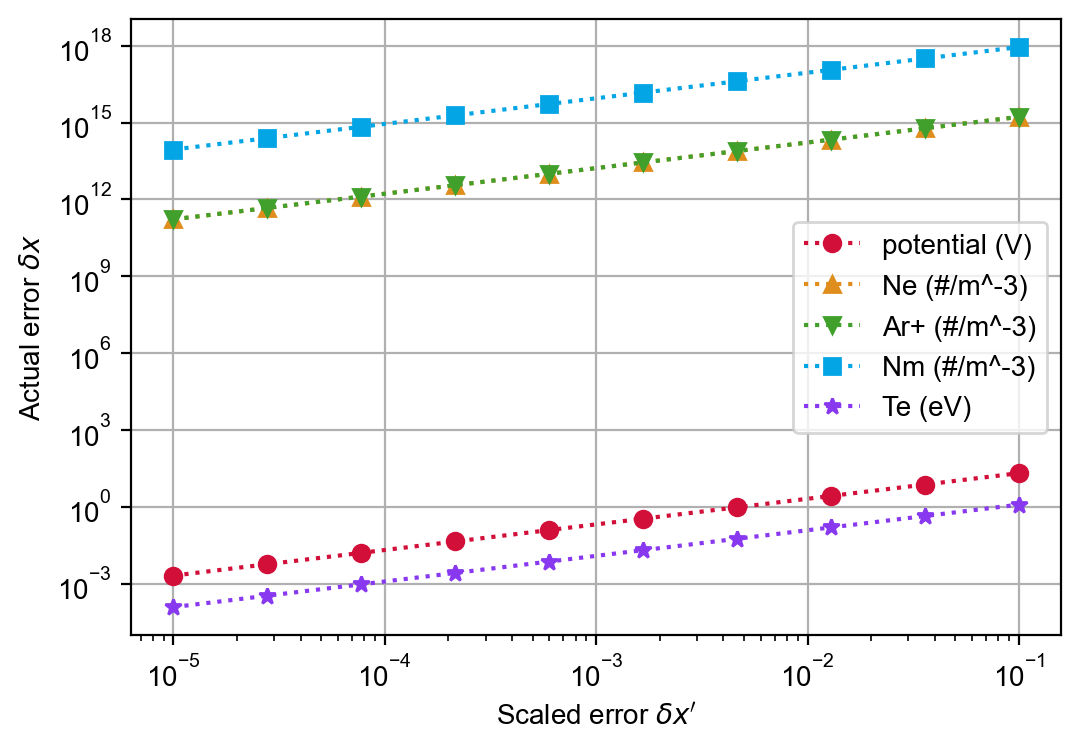

In [26]:
colors = ['#d20f39', '#df8e1d', '#40a02b', '#04a5e5', '#8839ef']
markers = ['o', '^', 'v', 's', '*']

fig, ax = plt.subplots(figsize=(6,4), dpi=200)
for i, column in enumerate(label_names):
    xmin, xmax = range_dict[column]
    dx = (xmax - xmin)*error
    ax.plot(error, dx, marker=markers[i], linestyle=':', color=colors[i], label=column)
    ax.grid()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Scaled error $\delta x\'$')
    ax.set_ylabel('Actual error $\delta x$')

fig

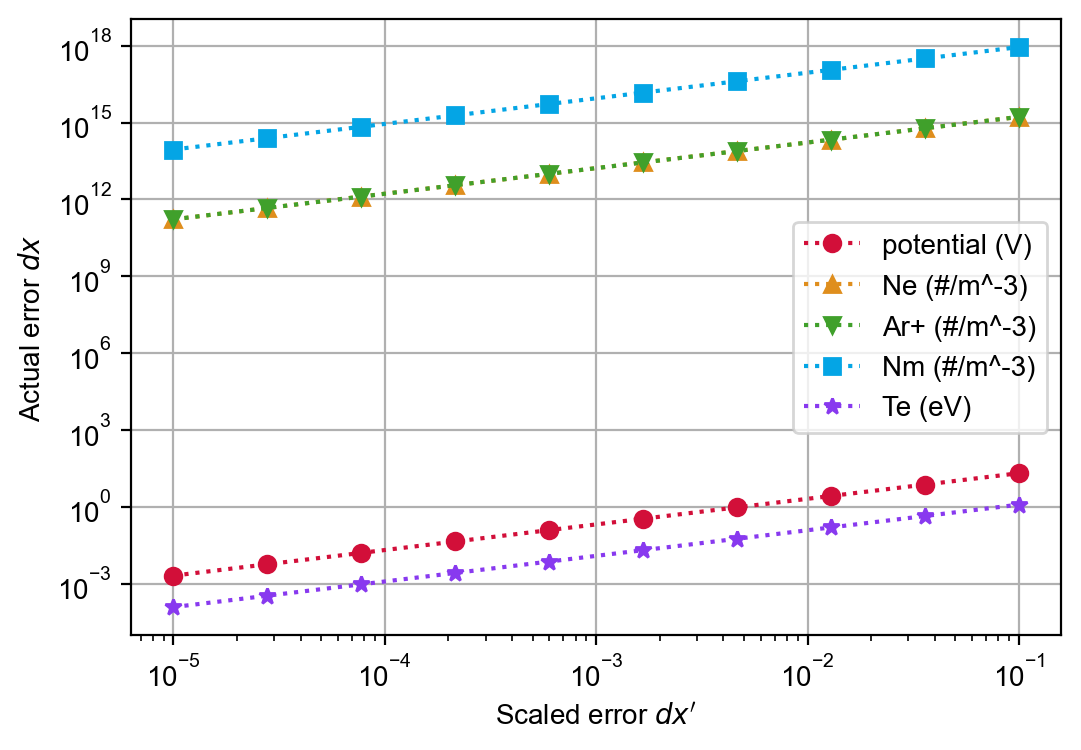

In [25]:
# fixed force a = 0
colors = ['#d20f39', '#df8e1d', '#40a02b', '#04a5e5', '#8839ef']
markers = ['o', '^', 'v', 's', '*']

fig, ax = plt.subplots(figsize=(6,4), dpi=200)
for i, column in enumerate(label_names):
    xmin, xmax = range_dict[column]
    dx = (xmax - 1e-10)*error
    ax.plot(error, dx, marker=markers[i], linestyle=':', color=colors[i], label=column)
    ax.grid()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Scaled error $dx\'$')
    ax.set_ylabel('Actual error $dx$')

fig
    

I'm not sure if my math is correct, but assuming that the values are scaled logarithmically before applying the minmax scaler, the scaling becomes

$x' = \frac{(\ln x - \ln a)}{\ln b - \ln a}$

and in reverse:

$x = \exp (a) [\exp (x'( \ln b - \ln a))$

$x = \exp (a) (\frac{b}{a})^{x'}$

from which the error $dx$ can be calculated:

$dx = \exp (a) (\frac{b}{a})^{x'} \ln(\frac{b}{a})) dx'$

It seems that error $dx$ does not only depend on the scaled error $dx'$, but also on the actual magnitude of the scaled value $x'$, which in this case ranges from around 0 to 0.5.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


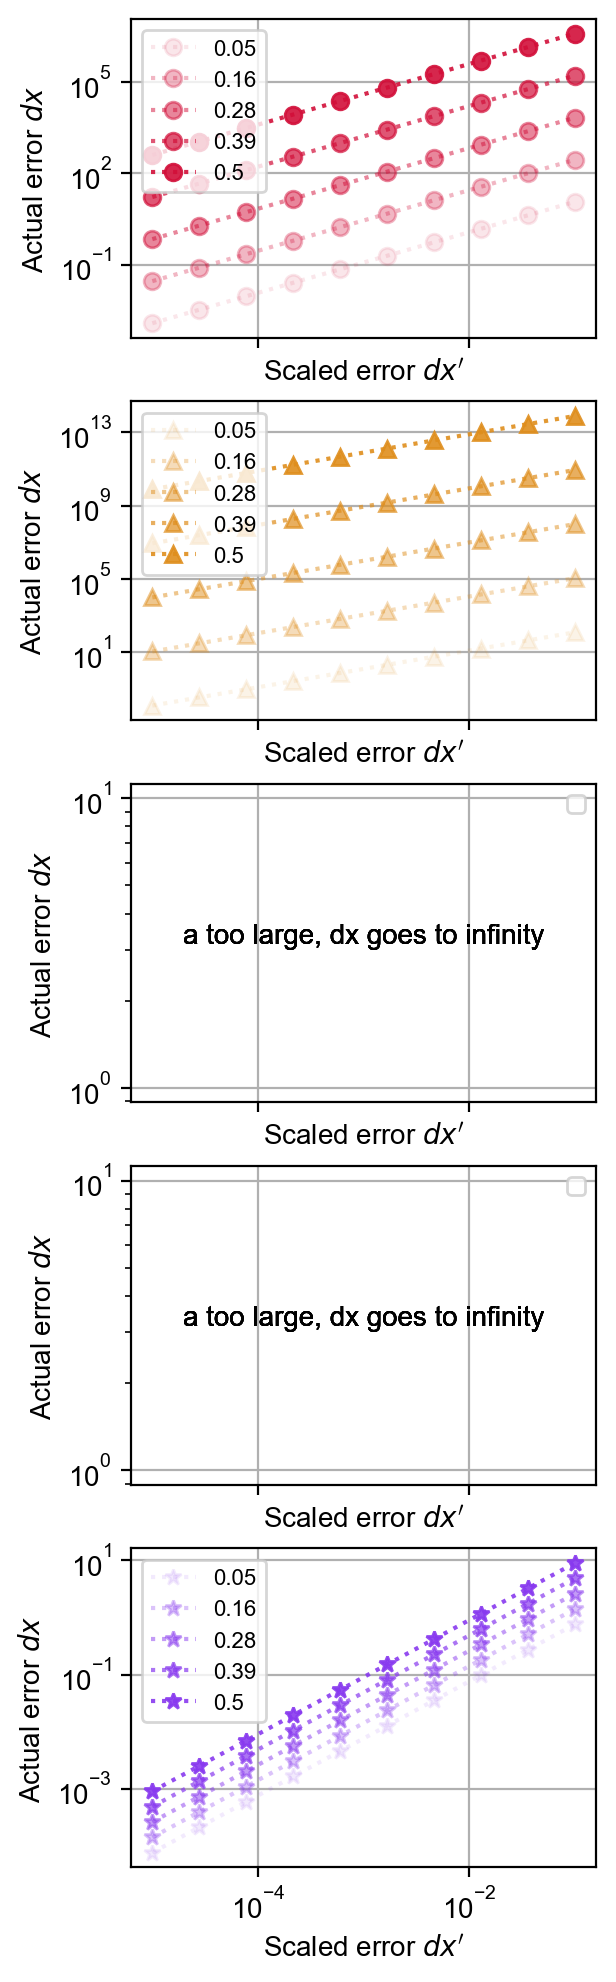

In [ ]:
import warnings
warnings.filterwarnings("error")

fig, ax = plt.subplots(figsize=(3,12), nrows=5, dpi=200, sharex=True)
for i, column in enumerate(label_names):
    for j, xp in enumerate(np.linspace(0.05, 0.5, 5)):
        a, b = range_dict[column]
        a += 1e-10
        
        try:
            dx = np.exp(a) * (b/a)**xp * np.log(b/a) * error
            ax[i].plot(error, dx, marker=markers[i], linestyle=':', color=colors[i], alpha=((j+0.5)/5), label=round(xp, 2))
        except:
            ax[i].text(0.5, 0.5, 'a too large, dx goes to infinity', ha='center', transform=ax[i].transAxes)

    ax[i].grid()
    ax[i].legend(fontsize=8)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Scaled error $dx\'$')
    ax[i].set_ylabel('Actual error $dx$')


In this example, number densities for ions and metastables does not have a curve because of an overflow exception in the $exp(a)$ function. This is because the values for $a$ for these quantities is extremely large, and $dx$ blows up to infinity. 

Assuming that the lowest possible value for all quantities is 0, then:

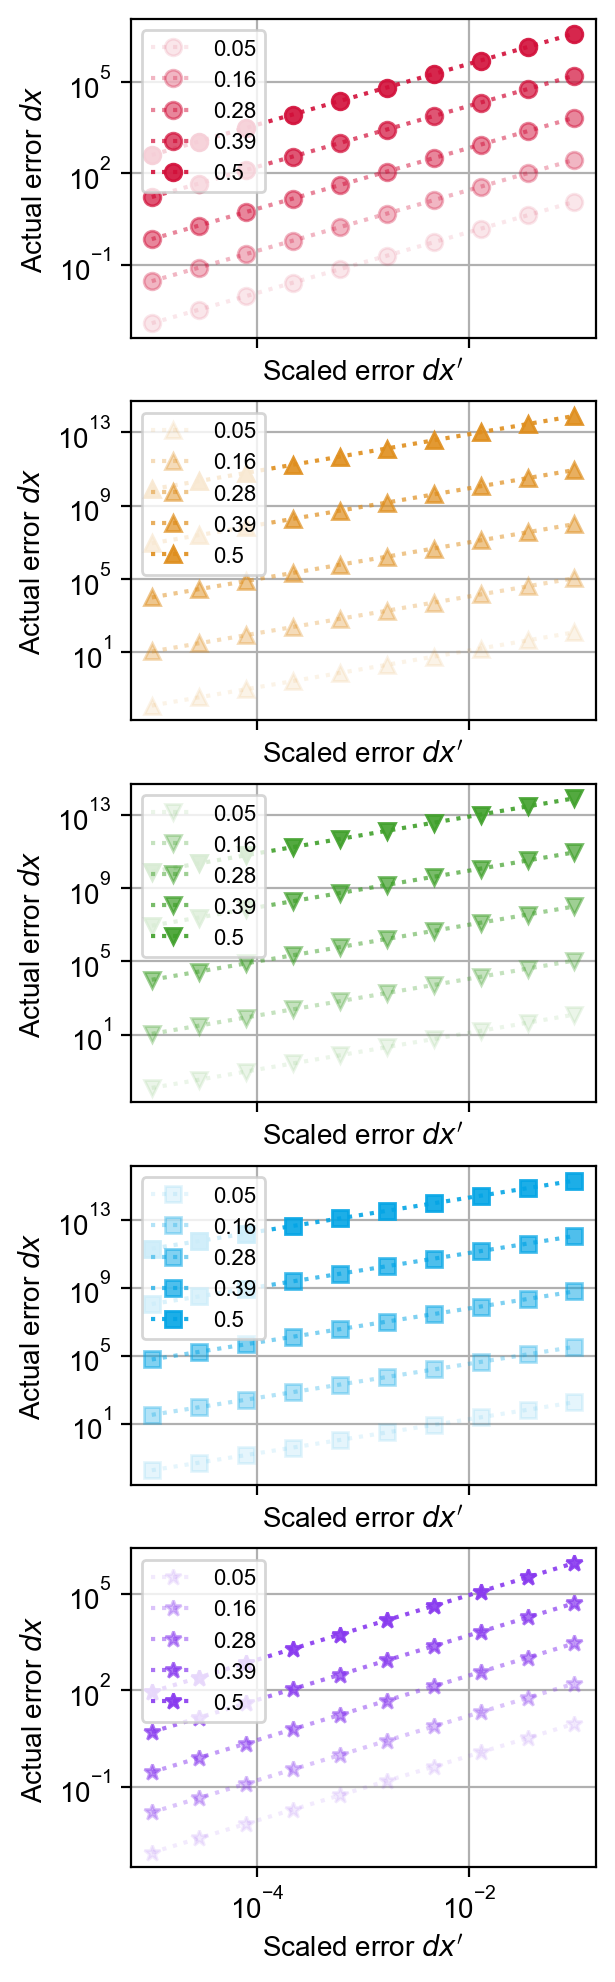

In [ ]:
import warnings
warnings.filterwarnings("error")

fig, ax = plt.subplots(figsize=(3,12), nrows=5, dpi=200, sharex=True)
for i, column in enumerate(label_names):
    for j, xp in enumerate(np.linspace(0.05, 0.5, 5)):
        a, b = range_dict[column]
        a = 1e-10
        
        try:
            dx = np.exp(a) * (b/a)**xp * np.log(b/a) * error
            ax[i].plot(error, dx, marker=markers[i], linestyle=':', color=colors[i], alpha=((j+0.5)/5), label=round(xp, 2))
        except:
            ax[i].text(0.5, 0.5, 'a too large, dx goes to infinity', ha='center', transform=ax[i].transAxes)

    ax[i].grid()
    ax[i].legend(fontsize=8)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Scaled error $dx\'$')
    ax[i].set_ylabel('Actual error $dx$')


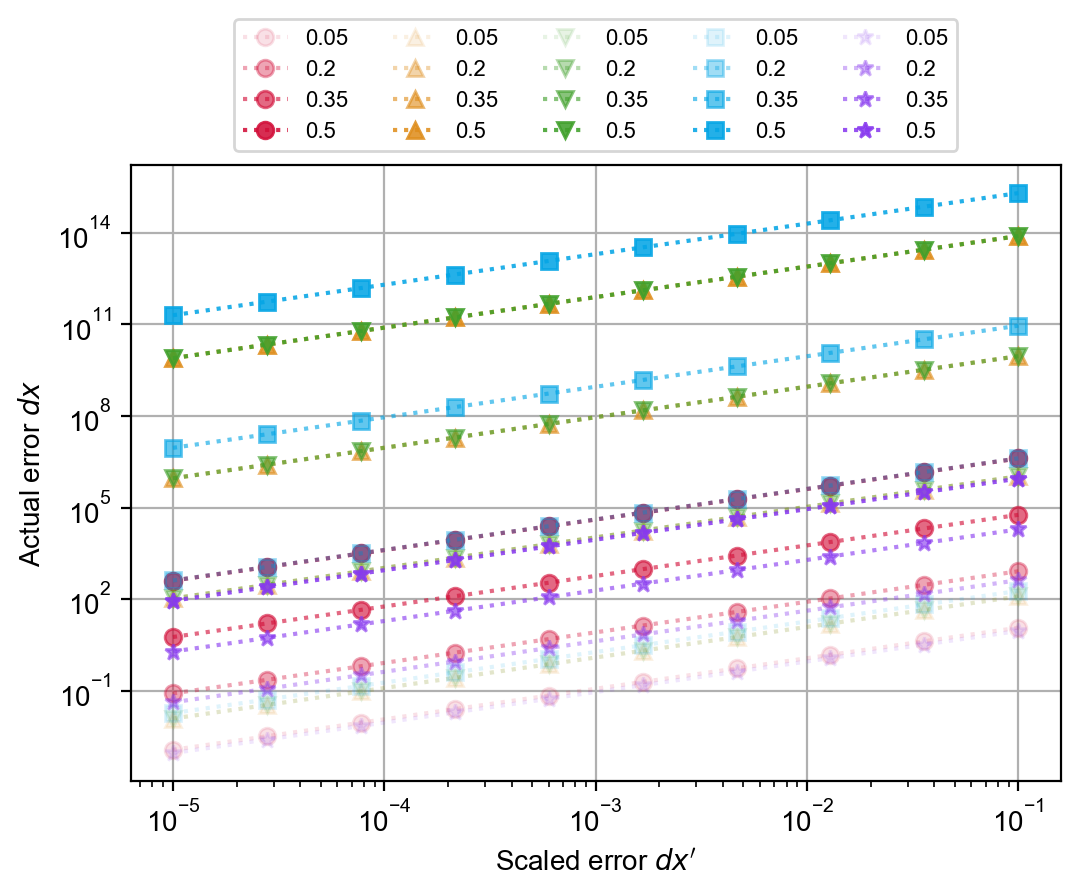

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
for i, column in enumerate(label_names):
    for j, xp in enumerate(np.linspace(0.05, 0.5, 4)):
        a, b = range_dict[column]
        a = 1e-10
        
        dx = np.exp(a) * (b/a)**xp * np.log(b/a) * error
        ax.plot(error, dx, marker=markers[i], linestyle=':', color=colors[i], alpha=((j+0.5)/4), label=round(xp, 2))
    ax.grid()
    ax.legend(loc='center', bbox_to_anchor=(0.5, 1.13), fontsize=8, ncol=5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Scaled error $dx\'$')
    ax.set_ylabel('Actual error $dx$')


It seems errors are smaller when they are scaled logarithmically. However, it must be noted that I have no idea what the typical $x'$ are in the log scale. Also, it seems that selecting proper values for scaling is important, as the error depends exponentially on $a$ when the scaling is reversed.

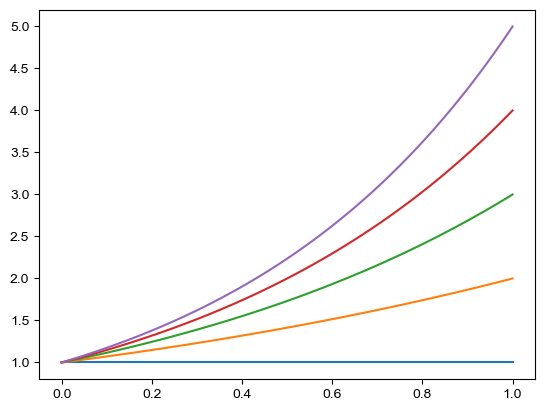

In [ ]:
fig, ax = plt.subplots()

xp = np.linspace(0, 1, 100)

for c in np.linspace(1, 5, 5):
    ax.plot(xp, c**xp)

In [ ]:
error

array([1.00000000e-05, 2.78255940e-05, 7.74263683e-05, 2.15443469e-04,
       5.99484250e-04, 1.66810054e-03, 4.64158883e-03, 1.29154967e-02,
       3.59381366e-02, 1.00000000e-01])